# Machine Learning: Assignment 1

In [1]:
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Import, leansing Setup and helper functions

Heatmap for Features


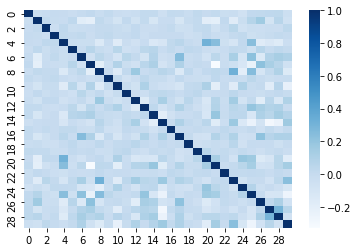

In [2]:
class Data():
    def dataAllocation(self,path):
        # df = pd.read_csv(path)
        # x_data = df.iloc[:, :-1]
        # y_data = df.iloc[:, -1 ]
        # return x_data,y_data
        X, y = make_classification(n_samples=2000, n_features=30, n_informative=20, n_redundant=0, random_state=6)
        return X, y
    def trainSets(self,x_data,y_data):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = 614, shuffle = True)
        return x_train, x_test, y_train, y_test

data = 'data/pima-indians-diabetes.csv'
dataset = Data()
x_data,y_data = dataset.dataAllocation(data)
x_train, x_test, y_train, y_test = dataset.trainSets(x_data,y_data)
print("Heatmap for Features")
data_corr = sns.heatmap(pd.DataFrame(x_train).corr(), cmap='Blues')

# 2. Decision Tree Classifier

In [11]:
class DTClassifier():
    def trainTest(self,x_train,x_test, y_train):

        params = ["Maximum Depth", "Minimum Leaf"]
        dfs= []
        for param in params:
            f1_scores_tests = []
            f1_scores_trains = []
            max_depths = [x for x in range(1,21)]
            
            for i in max_depths:
                if param == "Maximum Depth":
                    dt_clf = DecisionTreeClassifier(max_depth = i, random_state = 614)
                else:
                    dt_clf = DecisionTreeClassifier(min_samples_leaf = i, random_state = 614)
                dt_clf.fit(x_train, y_train)
                
                y_predict_train = dt_clf.predict(x_train)
                y_predict_test = dt_clf.predict(x_test)
                
                f1_scores_trains.append(f1_score(y_train, y_predict_train))
                f1_scores_tests.append(f1_score(y_test, y_predict_test))
            dfs.append(pd.DataFrame({param: max_depths, "Training F1 Scores": f1_scores_trains, "Testing F1 Scores": f1_scores_tests}))

        return dfs[0], dfs[1]
    
    def hyperParameterTuning(self,x_train,y_train):
        param_grid = {'min_samples_leaf': range(1, 21), 'max_depth': range(1, 21) }
        tune = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = param_grid, cv=5)
        return tune.fit(x_train, y_train)
    
    def bestParams(self,gscv_dtc):
        best_params = gscv_dtc.best_params_
        return best_params

    def bestScore(self,gscv_dtc):
        best_score = gscv_dtc.best_score_
        return best_score

dt = DTClassifier()
df_depth, df_leaf = dt.trainTest(x_train, x_test, y_train)

SyntaxError: invalid syntax (<ipython-input-11-86ba52690a7b>, line 12)

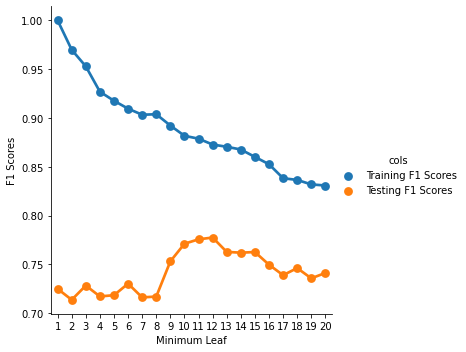

In [6]:
df_melt = df_leaf.melt("Minimum Leaf", var_name="cols", value_name="F1 Scores")
plot = sns.factorplot(data=df_melt, x="Minimum Leaf", y="F1 Scores", hue="cols")

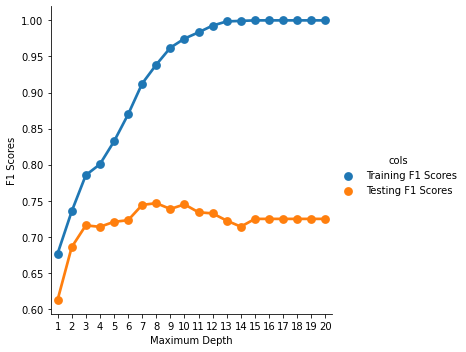

In [7]:
df_melt = df_depth.melt("Maximum Depth", var_name="cols", value_name="F1 Scores")
plot = sns.factorplot(data=df_melt, x="Maximum Depth", y="F1 Scores", hue="cols")

In [8]:
gscv_dtc = dt.hyperParameterTuning(x_train,y_train)
print("Decision Tree Best Parameters: ",dt.bestParams(gscv_dtc))
print("Decision Tree Best Score: ",dt.bestScore(gscv_dtc))

Decision Tree Best Parameters:  {'max_depth': 7, 'min_samples_leaf': 16}
Decision Tree Best Score:  0.7557142857142857


# 3. Support Vector Machine

In [15]:
class SupportVectorMachine():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test

    def trainTest(self,x_train, x_test, y_train):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        model = SVC(kernel = "linear")
        model.fit(scaled_x_train,y_train)
        y_predict_train = model.predict(scaled_x_train)
        y_predict_test = model.predict(scaled_x_test)
        return model, y_predict_train,y_predict_test

    def SVCTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy

    def SVCTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy

    def SVMBestScore(self, scaled_x_train, y_train):
        svm_parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1.0]}
        svm_tune = SVC(gamma = "auto")
        svm_cv = GridSearchCV(estimator = svm_tune, param_grid = svm_parameters, n_jobs=-1, return_train_score=True)
        svm_cv.fit(scaled_x_train, y_train)
        best_score = svm_cv.best_score_
        print(svm_cv.best_params_)
        return svm_cv, best_score

    def SVCClassifierParam(self,svm_cv,scaled_x_train,scaled_x_test,y_train):
        y_predict_train = svm_cv.predict(scaled_x_train)
        y_predict_test = svm_cv.predict(scaled_x_test)
        return y_predict_train, y_predict_test

    def svcTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy

    def svcTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy

    def SVMRankTestScore(self,svm_cv):
        rank_test_score = svm_cv.cv_results_['rank_test_score']
        return rank_test_score

    def SVMMeanTestScore(self,svm_cv):
        mean_test_score = svm_cv.cv_results_['mean_test_score']
        return mean_test_score

# svm = SupportVectorMachine()
# scaled_x_train, scaled_x_test = svm.dataPreProcess(x_train,x_test)
# y_predict_train,y_predict_test = svm.SVCClassifier(scaled_x_train,scaled_x_test, y_train)
# print("Support Vector Machine Trainn Accuracy: ",svm.SVCTrainAccuracy(y_train,y_predict_train))
# print("Support Vector Machine Test Accuracy: ",svm.SVCTestAccuracy(y_test,y_predict_test))
# svm_cv, best_score = svm.SVMBestScore(scaled_x_train, y_train)
# print("Support Vector Machine Best Score: ", best_score)
# y_predict_train,y_predict_test = svm.SVCClassifierParam(svm_cv,scaled_x_train,scaled_x_test,y_train)
# print("Support Vector Machine Train Accuracy: ",svm.svcTrainAccuracy(y_train,y_predict_train))
# print("Support Vector Machine Test Accuracy: ",svm.svcTestAccuracy(y_test,y_predict_test))
# print("Support Vector Machine Rank Test Score: ",svm.SVMRankTestScore(svm_cv))
# print("Support Vector Machine Mean Test Score: ",svm.SVMMeanTestScore(svm_cv))

In [16]:
classifiers = [DTClassifier(), SupportVectorMachine()]
for classifier in classifiers:
    model, y_predict_train,y_predict_test = classifier.trainTest(x_train, x_test, y_train)
    print(classification_report(y_test,y_predict_test))
    print(confusion_matrix(y_test,y_predict_test))



              precision    recall  f1-score   support

           0       0.75      0.71      0.73       297
           1       0.73      0.77      0.75       303

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600

[[210  87]
 [ 69 234]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       297
           1       0.80      0.77      0.78       303

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600

[[238  59]
 [ 71 232]]


# 4. KNN

In [5]:
class KNN():
    def kNeighborsClassifier(self,x_train,x_test, y_train, n_neighbors):
        dt_clf = KNeighborsClassifier(n_neighbors = n_neighbors)
        dt_clf.fit(x_train, y_train)
        y_predict_train = dt_clf.predict(x_train)
        y_predict_test = dt_clf.predict(x_test)
        return dt_clf,y_predict_train, y_predict_test
    
    def dtTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy
    
    def dtTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy

    def hyperParameterTuning(self,x_train,y_train):
        train_scores, test_scores = validation_curve(KNeighborsClassifier(), x_train, y_train, param_name="n_neighbors", param_range=range(1, 50), cv=5)
        return np.argmax(np.mean(test_scores, axis=1)) + 1
    
    
dt = KNN()
dt_clf,y_predict_train, y_predict_test = dt.kNeighborsClassifier(x_train,x_test, y_train, 3)
print("Decision Tree Train Accuracy: ",dt.dtTrainAccuracy(y_train,y_predict_train))
print("Decision Tree Test Accuracy: ",dt.dtTestAccuracy(y_test,y_predict_test))
n_neighbors_tuned = dt.hyperParameterTuning(x_train,y_train)
print("Optimal n_neighbors: ", n_neighbors_tuned)
dt_clf,y_predict_train, y_predict_test = dt.kNeighborsClassifier(x_train,x_test, y_train, n_neighbors_tuned)
print("Decision Tree Train Accuracy: ",dt.dtTrainAccuracy(y_train,y_predict_train))
print("Decision Tree Test Accuracy: ",dt.dtTestAccuracy(y_test,y_predict_test))


Decision Tree Train Accuracy:  0.9442857142857143
Decision Tree Test Accuracy:  0.8933333333333333
Optimal n_neighbors:  5
Decision Tree Train Accuracy:  0.9342857142857143
Decision Tree Test Accuracy:  0.9033333333333333


# 5. Neural Network

In [6]:
class NN():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test

    def mlpClassifier(self,scaled_x_train,scaled_x_test, y_train):
        model = MLPClassifier(max_iter=100)

        model.fit(scaled_x_train,y_train)
        y_predict_train = model.predict(scaled_x_train)
        y_predict_test = model.predict(scaled_x_test)
        return y_predict_train, y_predict_test, model

    def mlpTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy

    def mlpTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy
    
    def mlpBestScore(self, scaled_x_train, scaled_x_test, y_train, y_test, model):
        mlp_parameters = {
            'hidden_layer_sizes': [(10,30,10),(20,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
        mlp_cv = GridSearchCV(model, mlp_parameters)
        mlp_cv.fit(scaled_x_train, y_train)
        return mlp_cv, mlp_cv.predict(scaled_x_test)
    
    def optimizedTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy 

nn = NN()
scaled_x_train, scaled_x_test = nn.dataPreProcess(x_train,x_test)
y_predict_train,y_predict_test, model = nn.mlpClassifier(scaled_x_train,scaled_x_test, y_train)
print("Neural Network Train Accuracy: ",nn.mlpTrainAccuracy(y_train,y_predict_train))
print("Neural Network Test Accuracy: ",nn.mlpTestAccuracy(y_test,y_predict_test))
nn_tuned, y_predict_test_optimized = nn.mlpBestScore(scaled_x_train, scaled_x_test, y_train, y_test, model)
print("Neural Network Optimized Test Accuracy: ", nn.optimizedTestAccuracy(y_test, y_predict_test_optimized))


Neural Network Train Accuracy:  0.9728571428571429
Neural Network Test Accuracy:  0.935
Neural Network Optimized Test Accuracy:  0.895


# 6. Boost

In [7]:
class Boost():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test

    def gradientBoostingClassifier(self,scaled_x_train,scaled_x_test, y_train):
        model = GradientBoostingClassifier()

        model.fit(scaled_x_train,y_train)
        y_predict_train = model.predict(scaled_x_train)
        y_predict_test = model.predict(scaled_x_test)
        return y_predict_train, y_predict_test, model

    def gbTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy

    def gbTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy
    

boost = Boost()
scaled_x_train, scaled_x_test = boost.dataPreProcess(x_train,x_test)
y_predict_train,y_predict_test, model = boost.gradientBoostingClassifier(scaled_x_train,scaled_x_test, y_train)
print("Boosting Train Accuracy: ",boost.gbTrainAccuracy(y_train,y_predict_train))
print("Boosting Test Accuracy: ",boost.gbTestAccuracy(y_test,y_predict_test))

Boosting Train Accuracy:  0.96
Boosting Test Accuracy:  0.8633333333333333
